# Predicting building permit processing time using linear regression

In this notebook, we will try to predict how long the Chicago government will take to approve a building permit. The dataset comes from the [government of Chicago](https://data.cityofchicago.org/Buildings/Building-Permits/ydr8-5enu) and contains records from 2006-present. There are 650K rows and 119 columns, but most of the columns are of no use to us (contact information for up to 9 contacts). 

Here are some interesting columns: 

1. PERMIT_TYPE -- you can imagine that different permits take different amounts of time 
2. REVIEW_TYPE -- same as above 
3. APPLICATION_START_DATE -- are some years/months better than others? Are we getting better over time? Worse? 
4. ISSUE_DATE -- this may or may not be useful, based on how well-populated `PROCESSING_TIME` is
5. PROCESSING_TIME -- the target variable (the variable we are trying to predict)
6. STREET_NAME -- are some streets better or worse than others? May be too granular
7. TOTAL_FEE -- do higher or lower fees correlate with higher or lower processing times? One thing to note is that different permits will probably cost different amounts of money, so this feature may not provide any additional insight compared to `PERMIT_TYPE`
8. COMMUNITY_AREA -- unlike `STREET_NAME`, this is probably at an appropriate level to be potentially useful in predicting processing time (if there is any variation between communities, that is)
9. LATITUDE and LONGITUDE -- not useful for prediction but may come in useful for visualization 


We will start by visualizing the data and try to make a judgment on whether the dataset is a good fit for **linear regression**. If it is, then we will try to use linear regression to predict `PROCESSING_TIME`. 

Ok, let's get to it!

In [4]:
import numpy as np
import pandas as pd 
import seaborn as sns

from matplotlib import pyplot as plt 
from IPython.display import display 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [5]:
columns = [
    'PERMIT_TYPE', 'REVIEW_TYPE', 
    'APPLICATION_START_DATE', 'ISSUE_DATE', 'PROCESSING_TIME', 
    'STREET_NAME', 'COMMUNITY_AREA', 'LATITUDE', 'LONGITUDE', 'LOCATION', 
    'TOTAL_FEE'
]

df = pd.read_csv('Building_Permits.csv', usecols=columns, dtype={
    'COMMUNITY_AREA': 'string'})

display(df.shape)
display(df.dtypes)
display(df.head().T)

(650073, 11)

PERMIT_TYPE                object
REVIEW_TYPE                object
APPLICATION_START_DATE     object
ISSUE_DATE                 object
PROCESSING_TIME           float64
STREET_NAME                object
TOTAL_FEE                 float64
COMMUNITY_AREA             string
LATITUDE                  float64
LONGITUDE                 float64
LOCATION                   object
dtype: object

,0,1,2,3,4
PERMIT_TYPE,PERMIT - ELECTRIC WIRING,PERMIT - RENOVATION/ALTERATION,PERMIT - RENOVATION/ALTERATION,PERMIT - NEW CONSTRUCTION,PERMIT - ELECTRIC WIRING
REVIEW_TYPE,EASY PERMIT WEB,STANDARD PLAN REVIEW,STANDARD PLAN REVIEW,STANDARD PLAN REVIEW,EASY PERMIT WEB
APPLICATION_START_DATE,11/01/2005,11/01/2005,11/01/2005,11/01/2005,11/01/2005
ISSUE_DATE,11/19/2008,01/19/2006,01/10/2006,04/24/2006,07/07/2007
PROCESSING_TIME,1114,79,70,174,613
STREET_NAME,CRYSTAL,STAVE,RANDOLPH,LAWRENCE,MARINE
TOTAL_FEE,50,2973,7672,17210.2,40
COMMUNITY_AREA,23,<NA>,<NA>,<NA>,<NA>
LATITUDE,41.9036,41.9189,41.8846,41.968,41.9568
LONGITUDE,-87.7294,-87.6937,-87.6233,-87.7412,-87.6461


First, let's clean up the obvious problems with the data. `APPLICATION_START_DATE` and `ISSUE_DATE` should both be `datetime`s and `COMMUNITY_AREA` is a category variable, though it's a number. Let's also break up our start date into year, month, and day while we are at it, because we know that will come in useful. Finally, let's lowercase all column titles so they are easier to read and type.

In [6]:
df.columns = df.columns.str.lower()

df['community_area'] = df['community_area'].astype(str)

df['application_start_date'] = pd.to_datetime(df['application_start_date'])
df['issue_date'] = pd.to_datetime(df['issue_date'])

df['start_year'] = df.application_start_date.dt.year
df['start_month'] = df.application_start_date.dt.month
df['start_day'] = df.application_start_date.dt.day

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650073 entries, 0 to 650072
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   permit_type             650073 non-null  object        
 1   review_type             650066 non-null  object        
 2   application_start_date  649564 non-null  datetime64[ns]
 3   issue_date              650073 non-null  datetime64[ns]
 4   processing_time         649564 non-null  float64       
 5   street_name             650073 non-null  object        
 6   total_fee               650073 non-null  float64       
 7   community_area          650073 non-null  object        
 8   latitude                648137 non-null  float64       
 9   longitude               648137 non-null  float64       
 10  location                648137 non-null  object        
 11  start_year              649564 non-null  float64       
 12  start_month             649564

Next, let's look at the fill percentage of our columns. 

In [7]:
(df.notna().sum()/len(df) * 100).sort_values(ascending=False)

community_area            100.000000
total_fee                 100.000000
street_name               100.000000
issue_date                100.000000
permit_type               100.000000
review_type                99.998923
start_day                  99.921701
start_month                99.921701
start_year                 99.921701
processing_time            99.921701
application_start_date     99.921701
location                   99.702187
longitude                  99.702187
latitude                   99.702187
dtype: float64

This looks pretty good! Given that `processing_time` is what we're trying to predict, rows in which it's not present are not useful for us, so let's get rid of them. 

In [8]:
df = df[df.processing_time.notna()]

df.shape

(649564, 14)

In [9]:
df['start_year'] = (df.application_start_date.dt.year).astype(int)
df['start_month'] = (df.application_start_date.dt.month).astype(int)
df['start_day'] = (df.application_start_date.dt.day).astype(int)

## Data Visualization 

As always let's try to understand our data first. Some initial questions to guide our visualization process: 

1. What does our target variable (`processing_time`) look like? 
2. How many permits are issued each year, month, day? 
3. How many permits are issued by community? 
4. What's the relationship between each of our variables and `processing_time`? 
5. How many types of permits do we have? 
6. What are the different `review_type`s? 
7. How do fees vary with `permit_type`?
8. How do fees vary with `community_area`?

### `processing_time`

<AxesSubplot:xlabel='processing_time', ylabel='Count'>

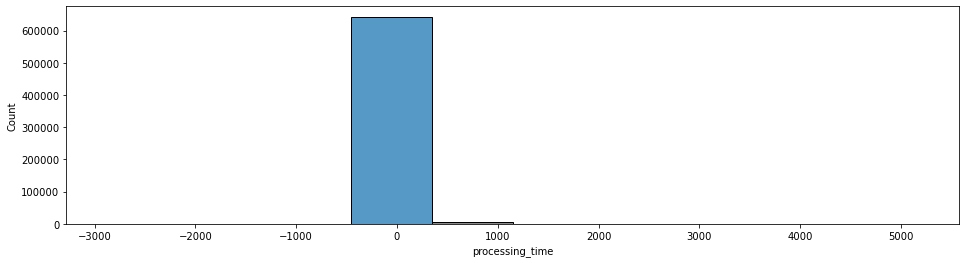

In [10]:
fig, ax = plt.subplots(figsize=(16,4))

sns.histplot(ax=ax, data=df.processing_time, stat='count', bins=10)

As usual, this is not that useful. A majority of the data is in one bucket with a small number of outliers on either side (though anything that takes less than 0 time is probably just bad data =)). So, let's try different ways of visualizing this. 

<AxesSubplot:xlabel='processing_time'>

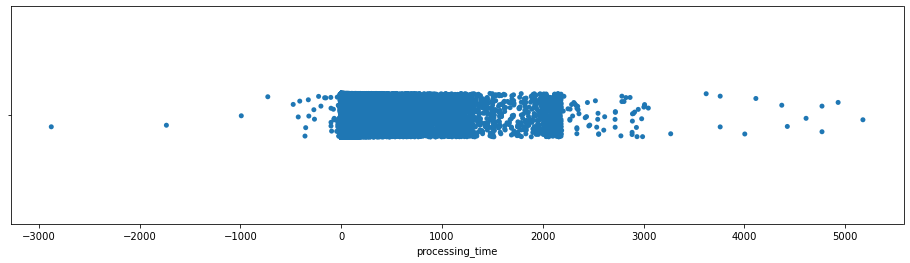

In [11]:
fig, ax = plt.subplots(figsize=(16,4))

sns.stripplot(ax=ax, x=df.processing_time, size=5)

Ok, so most permits were issued in under ~1000-2000 days (6 years) but some took way longer and a few required time travel. Let's look at the latter first; we'll probably need to delete them unless we can figure out an easy way to clean them. 

In [12]:
df[df.processing_time < 0][['application_start_date', 'issue_date', 'processing_time']]

,application_start_date,issue_date,processing_time
251,2006-01-17,2006-01-03,-14.0
5354,2006-03-08,2006-03-03,-5.0
5357,2006-03-08,2006-03-03,-5.0
5362,2006-03-08,2006-03-03,-5.0
6476,2006-12-05,2006-03-15,-265.0
...,...,...,...
639647,2010-05-04,2010-01-21,-103.0
643447,2008-08-07,2008-07-15,-23.0
648373,2021-01-21,2020-08-10,-164.0
648540,2006-02-21,2006-02-15,-6.0


Ok, these do look like just bad data (I was hoping only `processing_time` was wrong and we could recalculate it based on the `application_start_date` and `issue_date` but no such luck). Let's delete them. 

<AxesSubplot:xlabel='processing_time'>

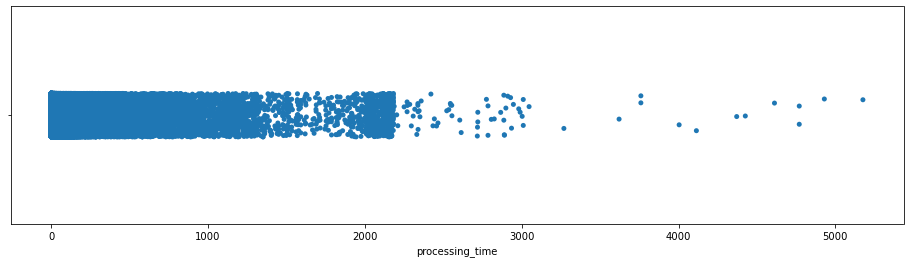

In [13]:
df = df[df.processing_time >= 0]

fig, ax = plt.subplots(figsize=(16,4))

sns.stripplot(ax=ax, x=df.processing_time, size=5)

Next, let's look at what the mean, median, and std look like. 

In [14]:
(
    df.processing_time.min(), df.processing_time.max(), 
    df.processing_time.mean(), df.processing_time.median(), 
    df.processing_time.std())

(0.0, 5176.0, 22.74379811541541, 0.0, 108.10977093796532)

Interestingly, median is 0d -- that means that most of the permits are being approved the same day they were submitted! 

In [15]:
display((
    len(df.processing_time[df.processing_time < 1]),
    len(df.processing_time[df.processing_time < 7]),
    len(df.processing_time[df.processing_time < 30]),
    len(df.processing_time[df.processing_time < 90]),
    len(df.processing_time[df.processing_time < 365]),
    len(df.processing_time) 
))

display((
    len(df.processing_time[df.processing_time < 1]) / len(df.processing_time) * 100,
    len(df.processing_time[df.processing_time < 7]) / len(df.processing_time) * 100,
    len(df.processing_time[df.processing_time < 30]) / len(df.processing_time) * 100,
    len(df.processing_time[df.processing_time < 90]) / len(df.processing_time) * 100,
    len(df.processing_time[df.processing_time < 365]) / len(df.processing_time) * 100,
    len(df.processing_time) / len(df.processing_time) * 100
))

(385988, 474244, 557423, 611794, 643397, 649480)

(59.43031348155448,
 73.01903060910266,
 85.82604545174601,
 94.19751185563837,
 99.0634045698097,
 100.0)

Over 50% are approved same day and nearly 95% are approved within a quarter. Let's `log10`-transform the data so we can see the data better. Before we can do that, though, we will have to do something about all the 0s, because `log(0)` is undefined. Let's set the 0s to 0.25 (a few hours) to get around this problem. 

In [16]:
df.processing_time = df.processing_time.replace({0: 0.25})

<AxesSubplot:xlabel='log10_processing_time', ylabel='Count'>

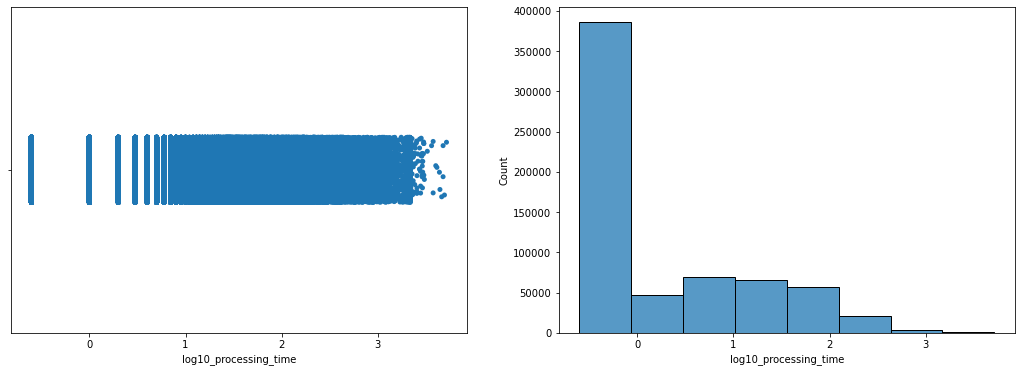

In [17]:
df['log10_processing_time'] = np.log10(df.processing_time)

fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.stripplot(ax=ax[0], x=df.log10_processing_time, size=5)
sns.histplot(ax=ax[1], x=df.log10_processing_time, stat='count', bins=8)

Notice that we have negative values again, but that's ok, because `log(numbers < 0) < 0`. 

### Permits by year

<AxesSubplot:xlabel='start_year', ylabel='log10_processing_time'>

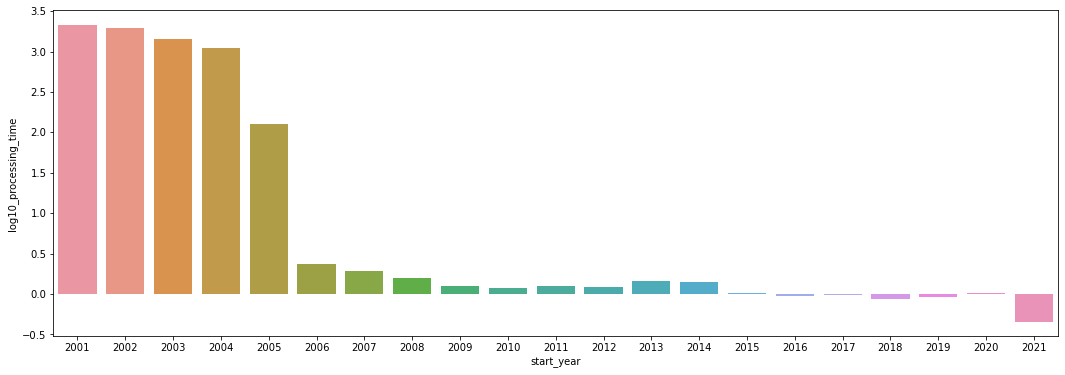

In [18]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(ax=ax, x='start_year', y='log10_processing_time', data=df, ci=None)

The government seems to have gotten much better at processing permits over the years -- look at the huge dropoff between 2004 -> 2006. Let's also plot the *number* of permits issued by year, because I suspect the numbers increased with time to keep the median so low. 

<AxesSubplot:label='5b60d37b-e2b1-473a-947d-443c9f42df3b', xlabel='start_year', ylabel='count'>

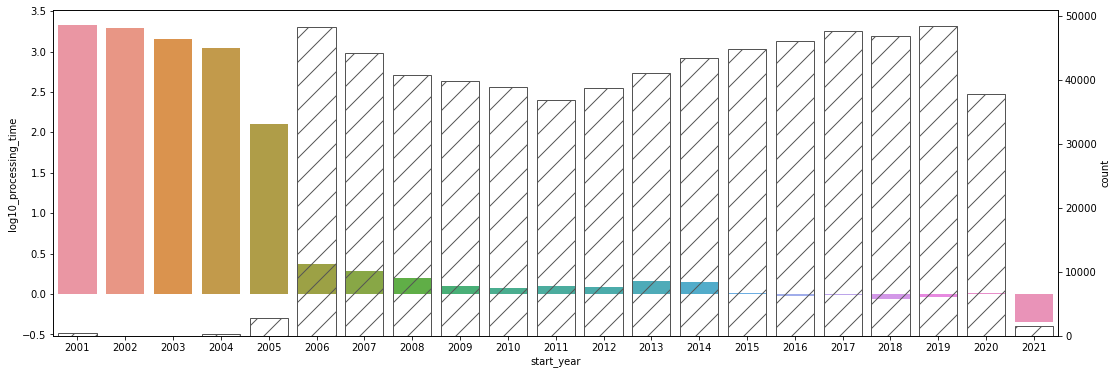

In [19]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(ax=ax, x='start_year', y='log10_processing_time', data=df, ci=None)

ax2 = ax.twinx()
sns.countplot(ax=ax2, x='start_year', data=df, fill=False, hatch='/', edgecolor='#555')

Ok, this looks like an artifact of the data rather than a sudden improvement in `processing_time`. Looking back at the information provided with the dataset (emphasis mine): 

> This dataset includes information about currently-valid building permits issued by the City of Chicago **from 2006** to the present. Building permits are issued subject to payment of applicable fees. If building or zoning permit fees show as unpaid, the permit is not valid. (A permit is valid if only “other fees” are shown as unpaid.) This dataset does not include permits which have been issued and voided or revoked. This dataset also does not include permits for mechanical amusement riding devices and carnivals issued by the Department of Buildings. 

So, we have some data from earlier, but, really, we should be looking at 2006 onwards. Let's delete the older data, because they are misleading. For similar reasons, let's also remove 2021. 

<AxesSubplot:label='3b4b9890-8e4d-4894-8aca-6d078ade2459', xlabel='start_year', ylabel='count'>

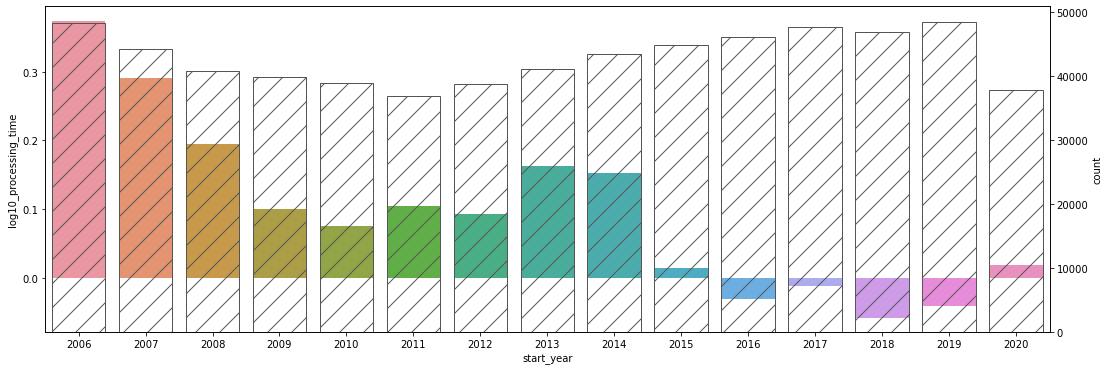

In [20]:
df = df[df.start_year >= 2006]
df = df[df.start_year < 2021]

fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(ax=ax, x='start_year', y='log10_processing_time', data=df, ci=None)

ax2 = ax.twinx()
sns.countplot(ax=ax2, x='start_year', data=df, fill=False, hatch='/', edgecolor='#555')

So, we still got better year over year (for the most part) but not dramatically so. In fact, let's plot the `processing_time` now, because it looks like the outliers are gone, too. 

<AxesSubplot:label='a11dd280-c0fb-4bce-8b15-3b7b566c8f1c', xlabel='start_year', ylabel='count'>

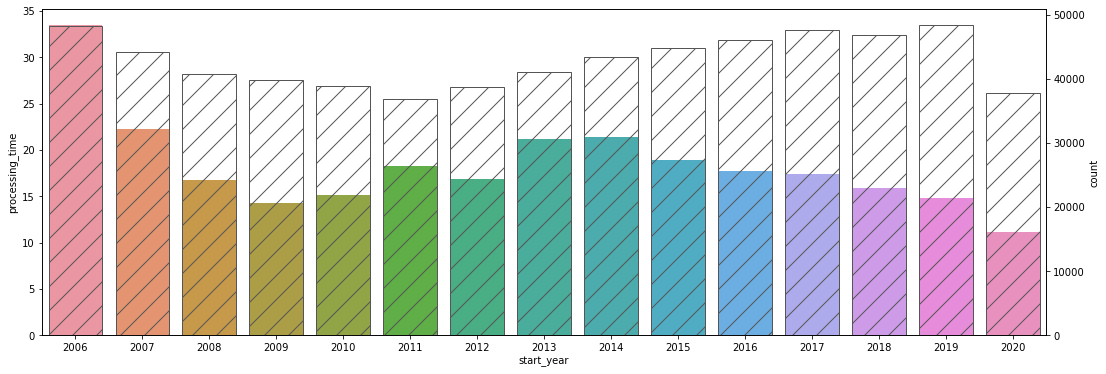

In [21]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(ax=ax, x='start_year', y='processing_time', data=df, ci=None)

ax2 = ax.twinx()
sns.countplot(ax=ax2, x='start_year', data=df, fill=False, hatch='/', edgecolor='#555')

This is much easier to read. 

Comparing 2006 and 2019 (which seem to have roughly similar number of permits), `processing_time` went from ~33d to ~13d. Sweet. 

Let's move on. 

### Permits by month

<AxesSubplot:label='9c7d737d-647d-4464-92e7-53b28adceea1', xlabel='start_month', ylabel='count'>

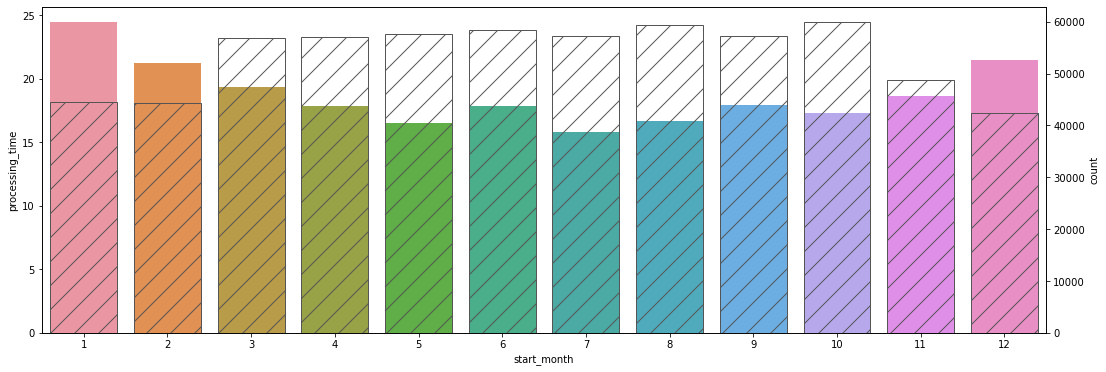

In [22]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(ax=ax, x='start_month', y='processing_time', data=df, ci=None)

ax2 = ax.twinx()
sns.countplot(ax=ax2, x='start_month', data=df, fill=False, hatch='/', edgecolor='#555')

People don't request as many permits November - February as they do in the other months. Something to do with it being holidays and/or winter? Maybe. =P

`processing_time` is also worse during December -> February, though there are fewer permits requested. March -> October also have roughly similar number of permits but the `processing_time` varies and not necessarily inline with number of permits (that is, higher volume doesn't imply higher `processing_time`). 

### Permits by day

<AxesSubplot:label='fc6802ae-49e4-4d92-a67c-64edcae91958', xlabel='start_day', ylabel='count'>

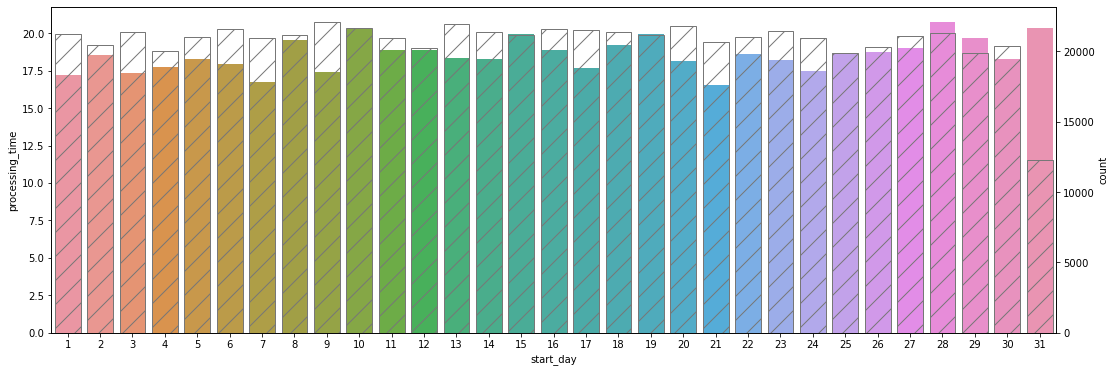

In [23]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(ax=ax, x='start_day', y='processing_time', data=df, ci=None)

ax2 = ax.twinx()
sns.countplot(ax=ax2, x='start_day', data=df, fill=False, hatch='/', edgecolor='#777')

Basically, not a lot of variation in number of permits. Day 31 looks way different, but most of that variation can be explained by half the months not having a 31st day. The variation in `processing_time` appears to be ~3d between days (at most). 

### Permits by community area

<AxesSubplot:label='7ec00a43-5569-4757-bbfe-c627c496aed1', xlabel='community_area', ylabel='count'>

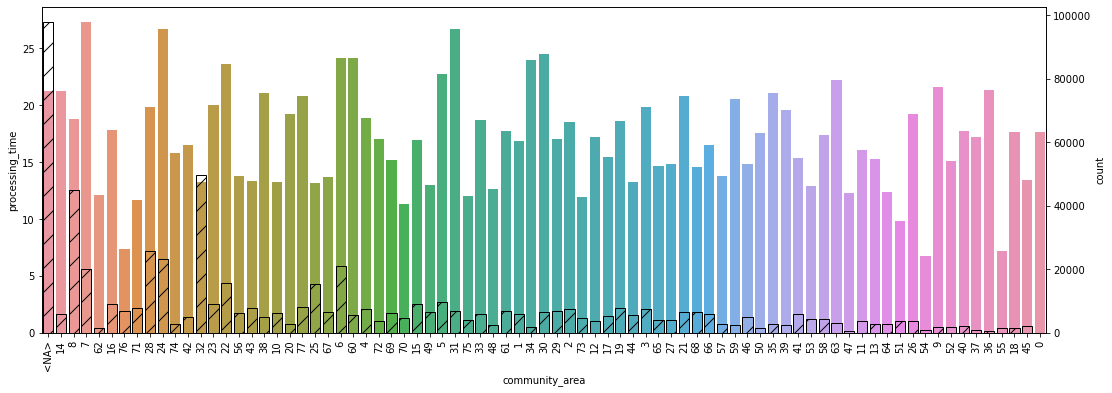

In [24]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(ax=ax, x='community_area', y='processing_time', data=df, ci=None)

for item in ax.get_xticklabels():
    item.set_rotation(90)

ax2 = ax.twinx()
sns.countplot(ax=ax2, x='community_area', data=df, fill=False, hatch='/')

This is not good -- look at the first column: `'nan'` --> I suspect this is an artifact of pandas initially reading this column as a `float` vs. `string`. Let's fix this. 

Ok, I went back and read the data right ... but we still have the `<NA>`s because that's what is in the data. That is, instead of leaving missing `community_area`s as blank, the dataset sets them to `<NA>`, instead. Ah, well. Let's look at the remaining `community_area`s.

There is definitely variation in both the number of permits requested by each community and the processing time for each community. These two variables (number of permits vs. processing time) don't appear to be correlated, though (higher number of permits doesn't imply higher processing time). 

### Permit types

PERMIT - ELECTRIC WIRING          226336
PERMIT - EASY PERMIT PROCESS      174655
PERMIT - RENOVATION/ALTERATION    129915
PERMIT - SIGNS                     41219
PERMIT - NEW CONSTRUCTION          23437
PERMIT - WRECKING/DEMOLITION       17856
PERMIT - ELEVATOR EQUIPMENT        15908
PERMIT - SCAFFOLDING                7944
PERMIT - REINSTATE REVOKED PMT      3414
PERMIT - PORCH CONSTRUCTION         2937
PERMIT - FOR EXTENSION OF PMT         58
Name: permit_type, dtype: int64

<AxesSubplot:xlabel='count', ylabel='permit_type'>

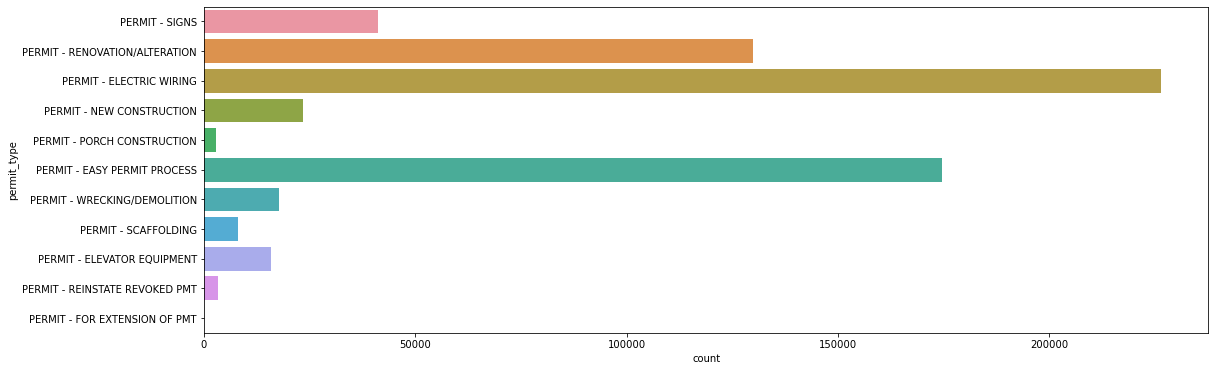

In [25]:
display(df['permit_type'].value_counts())

fig, ax = plt.subplots(figsize=(18,6))

sns.countplot(ax=ax, y='permit_type', data=df)

Clearly, a large variation in what types of permits are being requested. Let's see what `processing_time` looks like by `permit_type`. 

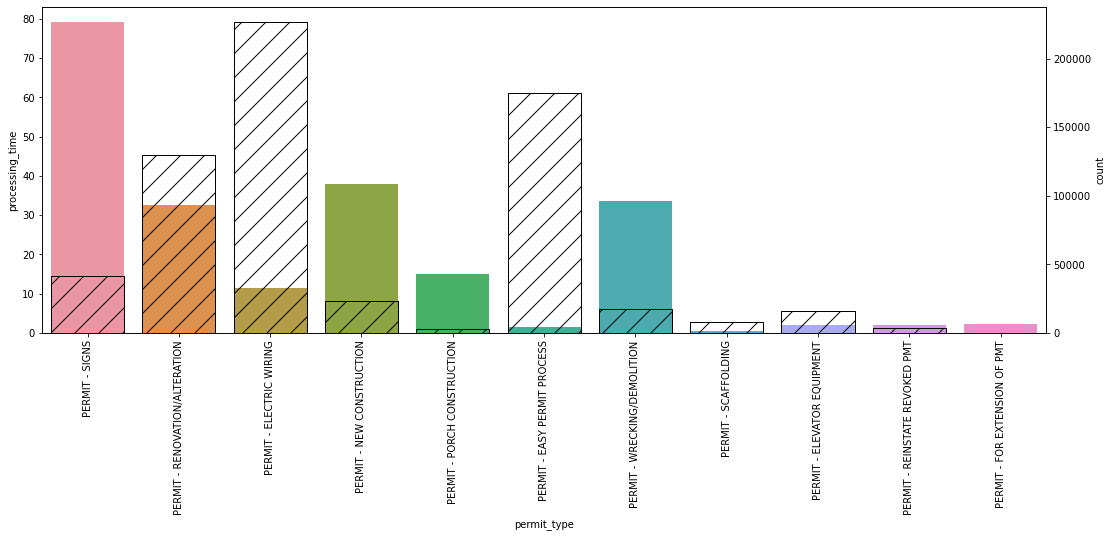

In [26]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(ax=ax, x='permit_type', y='processing_time', data=df, ci=None)

ax2 = ax.twinx()
sns.countplot(ax=ax2, x='permit_type', data=df, fill=False, hatch='/')
    
for item in ax.get_xticklabels():
    item.set_rotation(90)

No real relationship between number of permits issued for each type and processing time. The two most common permits take less than average amount of time, but some 'unpopular' permits take more time (ex., PERMIT - SIGNS) while others take less time (ex., PERMIT - SCAFFOLDING). 

But - there does seem to be quite a bit of variation between `permit_type`s, so that will come in useful when it comes to predictions. 

### Review types

EASY PERMIT WEB                   252475
EASY PERMIT                       149625
STANDARD PLAN REVIEW              112439
SIGN PERMIT                        41219
SELF CERT                          37513
DEMOLITION PERMIT                  17856
CONVEYANCE DEVICE PERMIT           15908
ELECTRICAL PLAN REVIEW              5530
TRADITIONAL DEVELOPER SERVICES      5406
FIRE PROTECTION SYSTEM              4908
DIRECT DEVELOPER SERVICES            798
Name: review_type, dtype: int64

<AxesSubplot:xlabel='count', ylabel='review_type'>

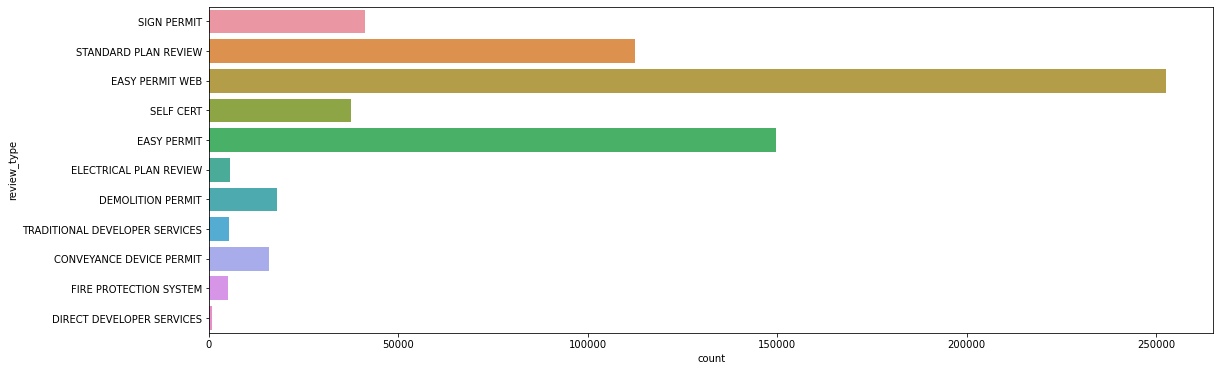

In [27]:
display(df['review_type'].value_counts())

fig, ax = plt.subplots(figsize=(18,6))

sns.countplot(ax=ax, y='review_type', data=df)

We see a similar variation based on `review_type`. Most permits are easy ones, apparently: `EASY PERMIT WEB`. 

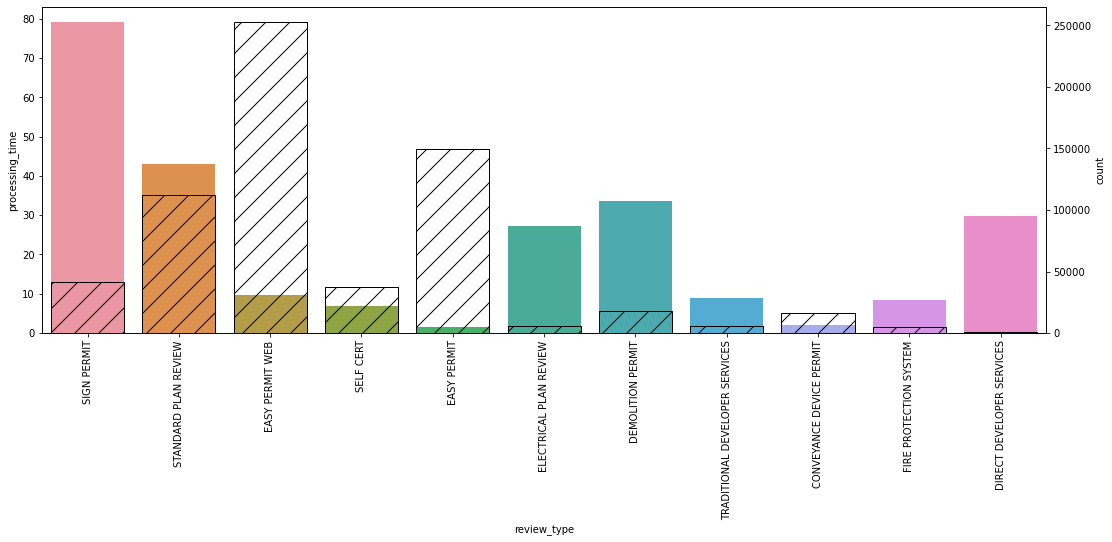

In [28]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(ax=ax, x='review_type', y='processing_time', data=df, ci=None)

ax2 = ax.twinx()
sns.countplot(ax=ax2, x='review_type', data=df, fill=False, hatch='/')
    
for item in ax.get_xticklabels():
    item.set_rotation(90)

Once again, we see variation by `review_type`, but, presumably, there's a link between `permit_type` and `review_type` -- let's look. 

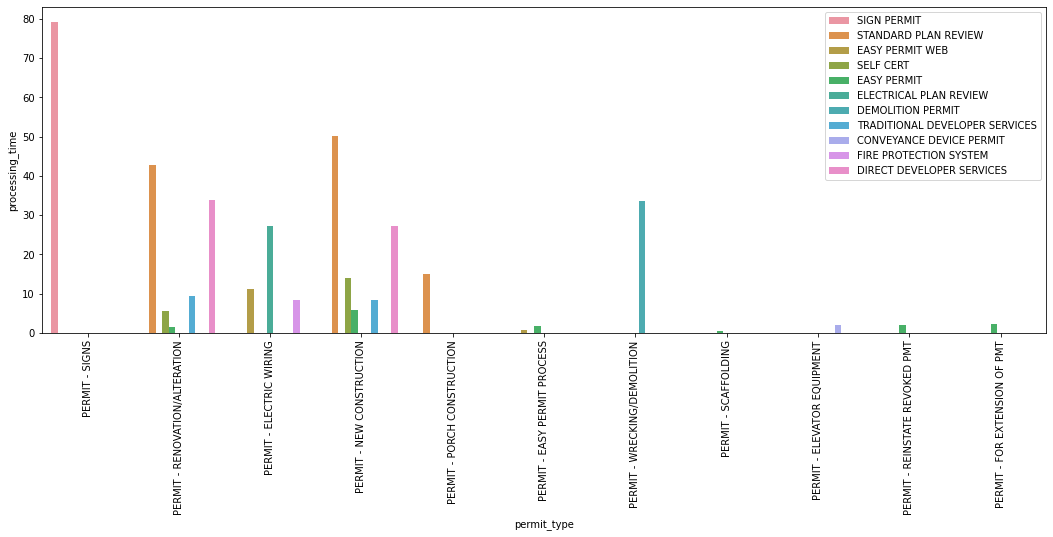

In [29]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(ax=ax, x='permit_type', y='processing_time', data=df, ci=None, hue='review_type')

for item in ax.get_xticklabels():
    item.set_rotation(90)
    
plt.legend(loc='upper right')

Most `permit_type`s are one-to-one with `review_type`s but others cross `review_type`s, which makes sense -- the `permit_type`s with multiple `review_type`s look more generic (i.e., may need different kind of reviews; ex., when you change electric wiring, you may need someone to go check that the wiring was done properly). 

### Fees by `permit_type`

<AxesSubplot:label='ea6a911e-0703-4520-b4a9-abe00e31d669', xlabel='processing_time', ylabel='permit_type'>

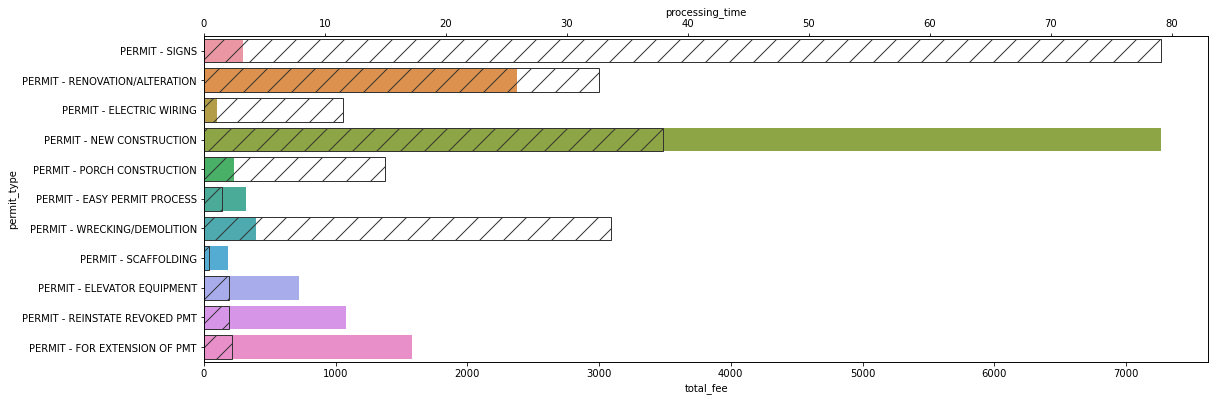

In [30]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(ax=ax, x='total_fee', y='permit_type', data=df, ci=None)

ax2 = ax.twiny()
sns.barplot(ax=ax2, x='processing_time', y='permit_type', data=df, 
            fill=False, hatch='/', ci=None, edgecolor='#333')

No noticeable relationship between fees and processing_time (i.e., the most expensive permits don't necessarily take the longest). 

### Fees by `review_type`

<AxesSubplot:label='0662b131-4265-4845-9122-3d63b6053dae', xlabel='processing_time', ylabel='review_type'>

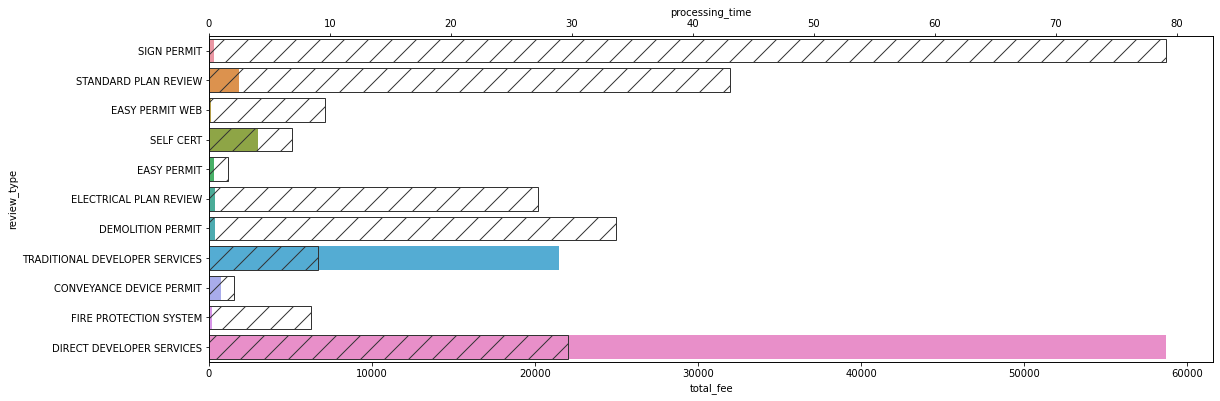

In [31]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(ax=ax, x='total_fee', y='review_type', data=df, ci=None)

ax2 = ax.twiny()
sns.barplot(ax=ax2, x='processing_time', y='review_type', data=df, 
            fill=False, hatch='/', ci=None, edgecolor='#333')

Once again, no relationship between fees and processing time, but there is a wide variation in fees by `review_type`, which makes sense. 

## Good dataset for linear regression?

So, what did our data analysis tell us? Is the data a good fit for linear regression? Should we even bother modeling? 

Well ... none of the features we looked at particularly show a linear relationship. Furthermore, all the features (except for fees, which we saw above weren't particularly prescriptive) we have are categorical in nature (`start_year` might be an int, but, really, it's a category). 

So ... **I *don't* think this is a good dataset for linear regression.** Below, you will find code to use linear regression to try to predict the processing_time anyway, and you'll notice that the error is quite large!

### Predicting `processing_time` via Linear Regression

Let's first figure out how to deal with category variables like `permit_type` and `review_type`, because they seem highly relevant. Because there are only a few unique values for each variable, let's do one-hot encoding on them.

We should do something similar for `start_year`, `start_month`, and `start_day`, too, because, though they are integers, they are more categorical (ex., +1 in month doesn't mean `processing_time` changes by x amount + you can't keep on adding 1 to month forever). 

In [32]:
dfs = df.copy()

dfs['review_type'] = dfs['review_type'].fillna('Unknown')

def encode_category_column(df, column_name):
    for value in df[column_name].unique():
        sanitized_value = str(value).replace(' ', '_').lower()
        
        feature = f'is_{column_name}_{sanitized_value}'
        feature_value = (df[column_name] == value).astype(int)
        df[feature] = feature_value 
        
    return df

dfs = encode_category_column(dfs, 'permit_type')
dfs = encode_category_column(dfs, 'review_type')
dfs = encode_category_column(dfs, 'start_year')
dfs = encode_category_column(dfs, 'start_month')
dfs = encode_category_column(dfs, 'start_day')

dfs.head().T

,18,23,29,30,31
permit_type,PERMIT - SIGNS,PERMIT - RENOVATION/ALTERATION,PERMIT - ELECTRIC WIRING,PERMIT - ELECTRIC WIRING,PERMIT - ELECTRIC WIRING
review_type,SIGN PERMIT,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT WEB,EASY PERMIT WEB
application_start_date,2007-10-16 00:00:00,2006-01-27 00:00:00,2006-01-12 00:00:00,2006-01-12 00:00:00,2006-01-12 00:00:00
issue_date,2008-03-05 00:00:00,2006-01-27 00:00:00,2006-01-12 00:00:00,2006-01-12 00:00:00,2006-01-12 00:00:00
processing_time,141,0.25,0.25,0.25,0.25
...,...,...,...,...,...
is_start_day_18,0,0,0,0,0
is_start_day_8,0,0,0,0,0
is_start_day_29,0,0,0,0,0
is_start_day_14,0,0,0,0,0


Let's train!

'MSE: 4629.879318939207'

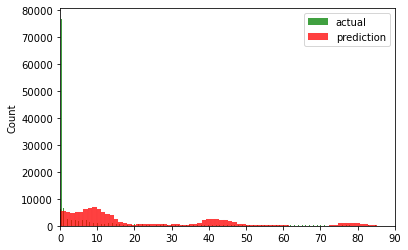

In [43]:
base_columns = ['processing_time', 'total_fee']
permit_columns = [col for col in dfs if col.startswith('is_permit_')]
review_columns = [col for col in dfs if col.startswith('is_review_')]
time_columns = [col for col in dfs if col.startswith('is_start_')]

columns = base_columns + permit_columns + review_columns + time_columns

def train(df, reg):
    train_X, test_X = train_test_split(df, test_size=0.2, random_state=42)

    train_y = train_X['processing_time'].values 
    test_y = test_X['processing_time'].values

    del train_X['processing_time']
    del test_X['processing_time']

    reg.fit(train_X, train_y)

    pred_y = reg.predict(test_X)
    coef = reg.coef_

    mse = mean_squared_error(test_y, pred_y)
    
    return (mse, pred_y, test_y, coef)

def run_model(df, reg_func):
    mse, pred_y, test_y, coef = train(df, reg_func)

    display(f'MSE: {mse}')

    ax = sns.histplot(test_y, label='actual', color='green')
    sns.histplot(pred_y, label='prediction', color='red', ax=ax)
    
    ax.set(xlim=(0,90))
    
    plt.legend()
    plt.show()

run_model(dfs[columns], LinearRegression())